In [1]:
import os
from torch_snippets import *

In [2]:
id2int = {'Parasitized':0 , 'Uninfected':1}


In [4]:
from torchvision import transforms as T

In [5]:
trn_tfms =T.Compose([
    T.ToPILImage() , 
    T.Resize(128) ,
    T.CenterCrop(128),
    T.ColorJitter(brightness=(0.95,1.05) , 
                 contrast=(0.95,1.05),
                 saturation=(0.95,1.05),
                  hue=0.05
                 ),
    T.RandomAffine(5, translate=(0.01,0.1)), 
    T.ToTensor() , 
    T.Normalize(mean = [0.5,0.5,0.5], 
               std=[0.5,0.5,0.5])
])

val_tfms = T.Compose([
    T.ToPILImage() , 
    T.Resize(128) , 
    T.CenterCrop(128) , 
    T.ToTensor() , 
    T.Normalize(mean=[0.5,0.5,0.5] , std=[0.5,0.5,0.5])
])

In [132]:
class MalariaImages(Dataset):
    def __init__(self, files,transform = None):
        self.files = files
        self.transform = transform
        logger.info(len(self))

    def __len__(self):
        return len(self.files)

    def __getitem__ (self, ix):
        fpath = self.files[ix]
        clss = os.path.basename(os.path.dirname(fpath))
        
        
        img = read(fpath , 1)
        return img , clss
    def choose(self):
        return self[randint(len(self))]
    def collate_fn(self, batch):
        _imgs, classes = list(zip(*batch))
        if self.transform:
            imgs = [self.transform(img)[None] for img in _imgs]
        classes = [torch.tensor([id2int[clss]]) for clss in classes]
        imgs, classes = [torch.cat(i).to(device) for i in [imgs, classes]]
        return imgs, classes, _imgs
        

In [133]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
all_files = Glob(os.getcwd()+"\\cell_images\\*\\*.png")

In [134]:
np.random.seed(10)
np.random.shuffle(all_files)


In [135]:
from sklearn.model_selection import train_test_split

In [136]:
trn_files , val_files = train_test_split(all_files , random_state=1)
trn_ds = MalariaImages(trn_files, transform= trn_tfms)
val_ds = MalariaImages(val_files , transform= val_tfms)

[06/11/24 22:37:43] INFO     20668                                                                                                                   ]8;id=887835;file://C:\Users\Acer\AppData\Local\Temp\ipykernel_49364\511423483.py:5\511423483.py]8;;\:]8;id=416634;file://C:\Users\Acer\AppData\Local\Temp\ipykernel_49364\511423483.py:5#__init__:5\__init__:5]8;;\

                    INFO     6890                                                                                                                    ]8;id=235610;file://C:\Users\Acer\AppData\Local\Temp\ipykernel_49364\511423483.py:5\511423483.py]8;;\:]8;id=844192;file://C:\Users\Acer\AppData\Local\Temp\ipykernel_49364\511423483.py:5#__init__:5\__init__:5]8;;\

In [137]:
trn_dl = DataLoader(trn_ds, 32, shuffle=True , collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds , 32 , shuffle =True , collate_fn=val_ds.collate_fn)

In [138]:
a,b,c =((list(zip(*next(iter(trn_dl)))))[0])

In [139]:
a.shape

torch.Size([3, 128, 128])

In [141]:
c.shape

(154, 148, 3)

In [142]:
b

tensor(1, device='cuda:0')

In [153]:
def convBlock(ni , no):
    return nn.Sequential(
        nn.Dropout(0.2),
        nn.Conv2d(ni , no , kernel_size=3 , padding=1) , 
        nn.ReLU(inplace=True), 
        nn.BatchNorm2d(no) ,
        nn.MaxPool2d(2) , 
    )


class MalariaClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(convBlock(3, 64),
        convBlock(64, 64),
        convBlock(64, 128),
        convBlock(128, 256),
        convBlock(256, 512),
        convBlock(512, 64),
        nn.Flatten(),
        nn.Linear(256, 256),
        nn.Dropout(0.2),
        nn.ReLU(inplace=True),
        nn.Linear(256, len(id2int)))
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self,x):
        return self.model(x)
    def compute_metrics(self, preds , targets):
        loss = self.loss_fn(preds , targets)
        acc = (torch.max(preds,1)[1] == targets).float().mean()
        return loss ,acc
    

In [154]:
def train_batch(model , data , optimizer , criterion):
    model.train()
    ims ,labels , _ = data
    _preds = model(ims)
    optimizer.zero_grad()
    loss , acc = criterion(_preds , labels)
    loss.backward()
    optimizer.step()
    return loss.item() ,acc.item()
@torch.no_grad()
def validate_batch(model , data , criteron):
    model.eval()
    ims , labels , _ = data
    _preds = model(ims)
    loss , acc = criterion(_preds , labels)
    return loss.item() , acc.item()
    

In [156]:
model = MalariaClassifier().to(device)
criterion = model.compute_metrics
optimizer = optim.Adam(model.parameters(), lr= 1e-3)
n_epochs = 1
log = Report(n_epochs)
for ex in range(n_epocs):
    N = len(trn_dl)
    for bx , data in enumerate(trn_dl):
        loss ,acc = train_batch(model ,data , optimizer , criterion)
        log.record(ex+(bx+1)/N , trn_loss = loss , trn_acc = acc, end= "\r")
    N = len(val_dl)
    for bx , data in enumerate(val_dl):
        loss ,acc = validate_batch(model , data ,criterion)
        log.record(ex+(bx+1)/N , val_loss =loss , val_acc = acc , end = "\r")

    log.report_avgs(ex+1)

C:\Program Files\Python312\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


EPOCH: 1.000  trn_loss: 0.262  val_loss: 0.283  trn_acc: 0.896  val_acc: 0.916  (153.75s - 0.00s remaining)


In [172]:
 im2fmap = nn.Sequential(*(list(model.model[:5].children()) +list(model.model[5][:2].children())))

In [182]:
def im2gradCAM(x):
    model.eval()
    logits = model(x)
    heatmaps = []
    activations = im2fmap(x)
    print(activations.shape)
    pred = logits.max(-1)[-1]
    model.zero_grad()
    logits[0 , pred].backward(retain_graph=True)
    pooled_grads = model.model[-7][1].weight.grad.data.mean((0,2,3))
    for i in range(activations.shape[1]):
        activations[:,i,:,:] *= pooled_grads[i]
        heatmap = torch.mean(activations, dim= 1 )[0].cpu().detach()
        return heatmap , 'Uninfected' if pred.item() else 'Parasitized'
    

In [180]:
len(model.model[-7][1].weight.grad.data.mean((0,2,3)))

256

In [181]:
model.model[-7][1]

Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [187]:
SZ= 128
def upsampleHeatmap(map , img):
    m , M = map.min() , map.max()
    map = 255 * ((map-m)/ (M-m))
    map = np.uint8(map)
    map = cv2.resize(map , (SZ , SZ))
    map = cv2.applyColorMap(255-map  , cv2.COLORMAP_JET)
    map = np.uint8(map)
    map = np.uint8(map*0.7 + img *0.3)
    return map

torch.Size([1, 64, 4, 4])


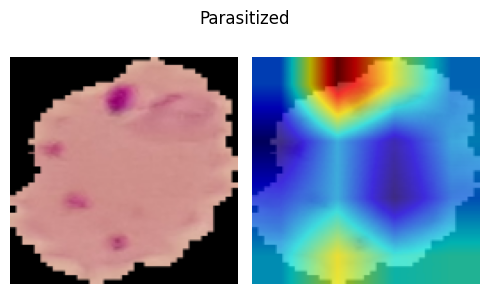

torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])


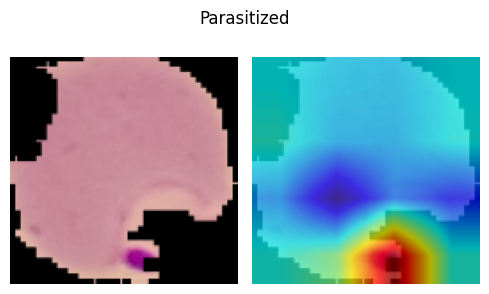

torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])


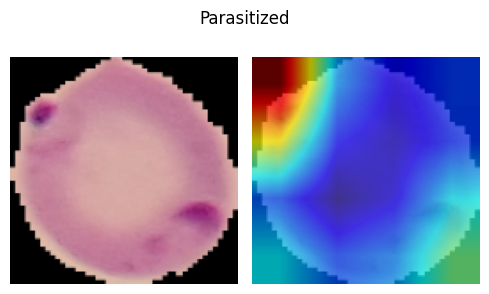

torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])


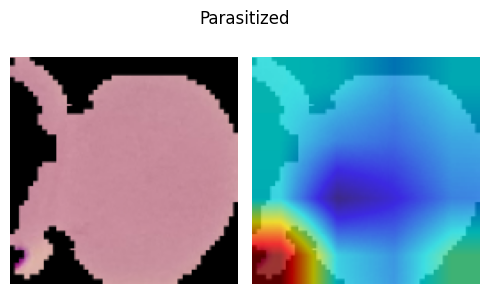

torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])


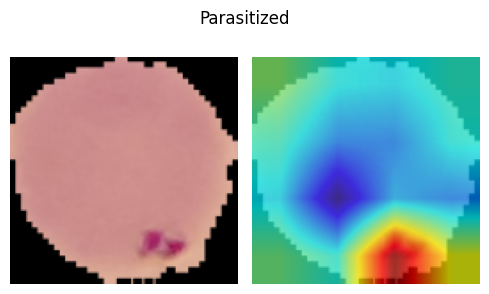

torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])


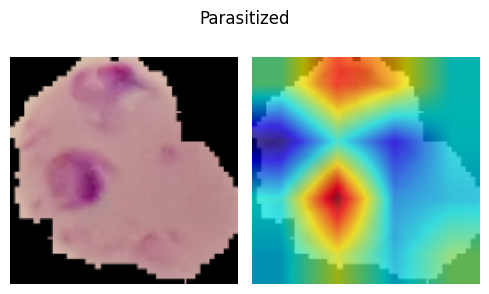

torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])


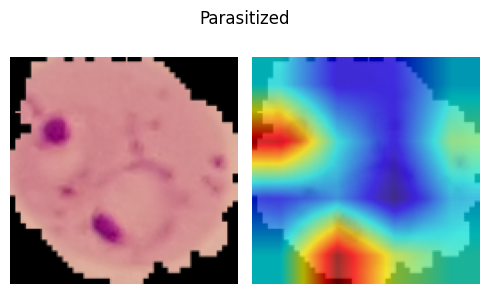

torch.Size([1, 64, 4, 4])


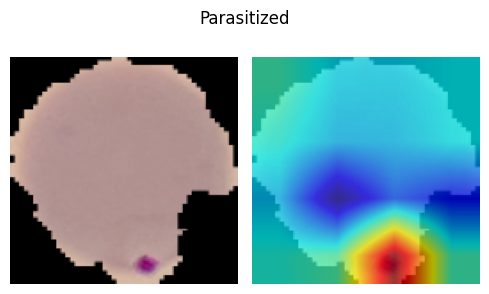

torch.Size([1, 64, 4, 4])


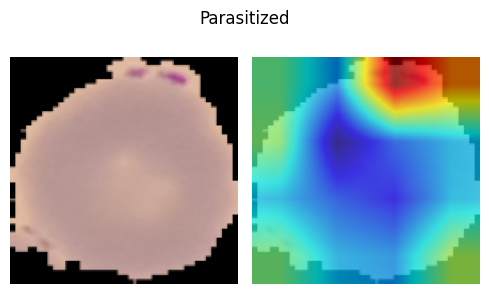

torch.Size([1, 64, 4, 4])


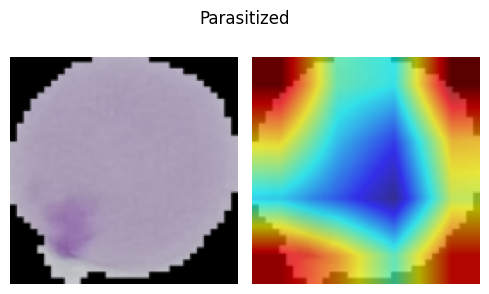

In [188]:
N = 20
_val_dl = DataLoader(val_ds, batch_size=N, shuffle=True, collate_fn=val_ds.collate_fn)
x,y,z = next(iter(_val_dl))

for i in range(N):
    image = resize(z[i], SZ)
    heatmap, pred = im2gradCAM(x[i:i+1])
    if(pred=='Uninfected'):
        continue
    heatmap = upsampleHeatmap(heatmap, image)
    subplots([image, heatmap], nc=2, figsize=(5,3), suptitle=pred)